In [1]:
# Loading necessary packages
import pandas as pd
import nltk
from rake_nltk import Rake
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
# Load the data set
cats_jp = pd.read_excel("CATS Example data CO & JPs.xlsb",sheet_name = 'Job Plan', header = 0, engine='pyxlsb')
cats_corr = pd.read_excel("CATS Example data CO & JPs.xlsb",sheet_name = 'Correctives', header = 0, engine='pyxlsb')

In [3]:
# Loading Sentence Transformer model for generating mean tokens of texts
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [4]:
# Extracting the WO and JP descriptions
wo_desc = cats_corr['DESCRIPTION'].tolist()
jp_desc = cats_jp['PM Description '].tolist()

In [5]:
# Encoding the WO and JP descriptions into embeddings
wo_desc_embed = model.encode(wo_desc)
jp_desc_embed = model.encode(jp_desc)

In [6]:
# Generating cosine similarity scores of WONUM embedding for each JP embedding (1:N)
wonum_match_score = []
for i in wo_desc_embed:
    cos_match = cosine_similarity([i],jp_desc_embed[:])
    score_list = np.array(cos_match).tolist()
    wonum_match_score.append(score_list[0])

In [7]:
def avg_value(l):
    return sum(l)/len(l)

In [8]:
avg_cosine_wos = [avg_value(i) for i in wonum_match_score]

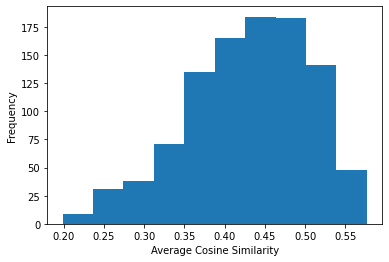

In [11]:
import matplotlib.pyplot as plt
plt.hist(avg_cosine_wos,bins = 10)
plt.xlabel("Average Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

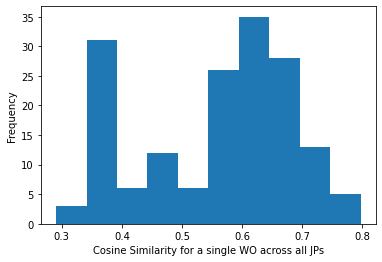

In [13]:
plt.hist(wonum_match_score[0],bins = 10)
plt.xlabel("Cosine Similarity for a single WO across all JPs")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Filtering out JP indices with cosine similarity > 0.60
high_score = []
high_inds = []
for i in wonum_match_score:
    hscore = [j for j in i if j>0.60]
    hind = [i.index(k) for k in hscore]
    high_score.append(hscore)
    high_inds.append(hind)

In [15]:
jp_list = cats_jp['JP '].tolist()

In [16]:
# Extracting JP IDs based on indices whose cosine similarity scores > 0.60
jp_nums = []
for i in high_inds:
    ref_list = [jp_list[j] for j in i]
    jp_nums.append(ref_list)

In [17]:
# Removing Duplicate JP IDs
unique_jp_nums = [list(dict.fromkeys(i)) for i in jp_nums]

In [18]:
# Generating the mapping data frame for WONUM and JPs
wonum_jp_match_bert = pd.DataFrame({
    'WONUM':cats_corr['WONUM'].tolist(),
    'JP':unique_jp_nums
})

In [19]:
wonum_jp_match_bert.to_excel('WONUM_JP_Bert_Cosine.xlsx', index = False)